In [ ]:
pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.6 MB/s eta 0:00:00


In [ ]:
# COMP 5900J Winter 2024 Assignment 1
# Carleton University
# NOTE: We provide some helper functions here.
#       See the A1 instructions for more information.
import numpy as np
from scipy.linalg import block_diag
import matplotlib
from matplotlib import pyplot as plt
import gymnasium as gym
from gymnasium.error import DependencyNotInstalled
import numpy as np
from scipy.linalg import block_diag
import matplotlib
from matplotlib import pyplot as plt

In [ ]:
# Some basic np array manipulations
a = np.array([1, 2, 3])

print(f"The shape of a is {a.shape}")

print(f"The last element of a is {a[-1]}")

print(f"Everything until the last element of a: {a[:-1]}")

# extending dimension
a = a[:, None]
print(f"The shape of a after extension is {a.shape}")

# remove dimension
a = a.flatten()  # or a = a[:, 0]
print(f"The shape of a after removing dimension is {a.shape}")

The shape of a is (3,)
The last element of a is 3
Everything until the last element of a: [1 2]
The shape of a after extension is (3, 1)
The shape of a after removing dimension is (3,)


In [ ]:
# solving Ax=b
A = np.array([[1, -0.4, -0.4],
              [-0.4, 1, -0.4],
              [-0.4, -0.4, 1]])
b = np.array([[2.4],
              [-0.4],
              [-1.8]])
# b = np.array([2.4, -0.4, -1.8])  # try this

x = np.linalg.solve(A, b)
print(x)

x = np.linalg.inv(A) @ b
print(x)

[[ 2.00000000e+00]
 [-3.96508223e-16]
 [-1.00000000e+00]]
[[ 2.00000000e+00]
 [-2.85485921e-16]
 [-1.00000000e+00]]


In [ ]:
class GridWorld(gym.Env):

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 20}

    def __init__(self, render_mode=None, init_state=None, goal=None):

        if not hasattr(self, 'layout'):
            raise ValueError("Need layout in subclass")

        # Parse the layout
        layout_lines = self.layout.splitlines()
        self._occupancy = np.array([list(map(lambda c: 1 if c == 'w' else 0, line))
                                    for line in layout_lines])

        # From any state the agent can perform one of four actions, up, down, left or right
        self._n_actions = 4
        self._n_states = int(np.sum(self._occupancy == 0))

        self._directions = [
            np.array((-1, 0)), np.array((1, 0)), np.array((0, -1)), np.array((0, 1))]

        self._to_state = {}  # maps (x, y) to state #
        state_num = 0
        self._limits = [len(layout_lines), len(layout_lines[0])]
        for i in range(len(layout_lines)):
            for j in range(len(layout_lines[0])):
                if self._occupancy[i, j] == 0:
                    self._to_state[(i, j)] = state_num
                    state_num += 1
        # maps state # to (x, y)
        self._to_cell = {v: k for k, v in self._to_state.items()}

        self._goal = goal

        if init_state is None:
            self._init_states = list(range(self._n_states))
            self._init_states = np.delete(
                self._init_states, goal)  # remove goal
        else:
            assert init_state != goal
            self._init_states = [init_state]

        if goal is not None:
            self._reward_func = self._compute_reward_func()

        self._current_cell = None

        self.window_cell_size = 50  # The length of a cell in the PyGame window
        self.window_size = np.array(self._limits) * self.window_cell_size

        # Standard Gym interface
        self.observation_space = gym.spaces.Box(low=0,
                                                high=self.n_states-1,
                                                dtype=int)  # cell index
        self.action_space = gym.spaces.Discrete(self.n_actions)
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        self.window = None  # window we draw to
        self.clock = None  # control framerate
        self._transition_func = self._compute_transition_func()

        self._current_cell = None

    def _compute_reward_func(self):
        """
            Compute the reward function r(s, a)
        """

        reward_func = np.zeros([self._n_states,
                                self._n_actions])

        goal_cell = self._to_cell[self._goal]
        # cells reachable from goal
        neighbor_cells = self._alt_cells(goal_cell, None)
        for cell in neighbor_cells:
            state = self._to_state[cell]
            for action in range(self._n_actions):
                next_cell = tuple(cell +
                                  self._directions[action])
                if not self._occupancy[next_cell]:
                    next_state = self._to_state[next_cell]
                    if next_state == self._goal:
                        reward_func[state, action] += 1

        # it is possible to keep hitting walls after reaching the goal
        for action in range(self._n_actions):
            next_cell = tuple(goal_cell +
                              self._directions[action])
            if self._occupancy[next_cell]:
                reward_func[self._goal, action] += 1

        return reward_func.reshape([self._n_states * self._n_actions,
                                    1])

    def _compute_transition_func(self):
        # compute the transition probability matrix P

        p = np.zeros([self._n_states, self._n_actions, self._n_states])

        for s in range(self._n_states):

            cell = self._to_cell[s]

            for a in range(self._n_actions):

                next_cell = tuple(cell + self._directions[a])
                if not self._occupancy[next_cell]:
                    p[s, a, self._to_state[next_cell]] = 1
                    alt_cells = self._alt_cells(cell, next_cell)
                    for c in alt_cells:
                        p[s, a, self._to_state[c]] = 0
                else:  # bump into wall, so stay the same
                    p[s, a, s] = 1.

        return p.reshape([self._n_states * self._n_actions,
                          self._n_states])

    def _alt_cells(self, cell, next_cell=None):

        alt_cells = []
        for action in range(self._n_actions):
            alt_cell = tuple(cell + self._directions[action])
            if not self._occupancy[alt_cell] and alt_cell != next_cell:
                alt_cells.append(alt_cell)
        return alt_cells

    def reset(self, init_state=None):

        if init_state is not None:
            # assert init_state in self._init_states
            state = init_state
        else:
            state = np.random.choice(self._init_states)
        self._current_cell = self._to_cell[state]

        if self.render_mode == "human":
            self.render()

        return state, {}

    def step(self, action):
        """
        The agent can perform one of four actions:
                             up, down, left or right
        If the movement would take the agent into a wall
        then the agent remains in the same cell.

        We consider a case in which reward is 1 when reach the goal and 0 everywhere else.
        """

        next_cell = tuple(self._current_cell + self._directions[action])

        if not self._occupancy[next_cell]:
            self._current_cell = next_cell

        state = self._to_state[self._current_cell]

        terminated = state == self._goal
        reward = 1 if terminated else 0.

        if self.render_mode == "human":
            self.render()

        return state, reward, terminated, False, {}

    def render(self):

        # PyGame has a different coordinate system (flip)
        try:
            import pygame
        except ImportError as e:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gymnasium[classic-control]`"
            ) from e

        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(np.flip(self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface(np.flip(self.window_size))
        canvas.fill((255, 255, 255))

        # First we draw the goal
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                self.window_cell_size * np.flip(self._to_cell[self.goal]),
                (self.window_cell_size, self.window_cell_size),
            ),
        )

        # Draw the walls
        for i in range(self._limits[0]):
            for j in range(self._limits[1]):
                if self._occupancy[i, j]:
                    pygame.draw.rect(
                        canvas,
                        0,
                        pygame.Rect(
                            (j * self.window_cell_size, i * self.window_cell_size),
                            (self.window_cell_size, self.window_cell_size),
                        ),
                    )

        # Draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (np.flip(self._current_cell) + 0.5) * self.window_cell_size,
            self.window_cell_size / 3,
        )

        # Finally, add some gridlines
        for i in range(self._limits[0]):
            pygame.draw.line(
                canvas,
                0,
                (0, self.window_cell_size * i),
                (self.window_size[1], self.window_cell_size * i),
                width=3,
            )
        for i in range(self._limits[1]):
            pygame.draw.line(
                canvas,
                0,
                (self.window_cell_size * i, 0),
                (self.window_cell_size * i, self.window_size[0]),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()

    @property
    def P(self):
        return self._transition_func

    @property
    def init_states(self):
        return self._init_states

    @property
    def goal(self):
        return self._goal

    @property
    def n_actions(self):
        return self._n_actions

    @property
    def n_states(self):
        return self._n_states

    @property
    def r(self):
        return self._reward_func

    @property
    def to_cell(self):
        return self._to_cell

    @property
    def to_state(self):
        return self._to_state


class FourRoom(GridWorld):

    def __init__(self, render_mode=None, init_state=None, goal=None):
        if goal is None:
            goal = 72
        self.layout = """\
wwwwwwwwwwwww
w     w     w
w     w     w
w           w
w     w     w
w     w     w
ww wwww     w
w     www www
w     w     w
w     w     w
w           w
w     w     w
wwwwwwwwwwwww
"""
        super().__init__(render_mode=render_mode,
                         init_state=init_state,
                         goal=goal)


        #self._init_states = [0]

In [ ]:
import numpy as np
def iterativePolicyEvaluation(env, Pi, gamma, tol=1e-10):
    """
        Iterative policy evaluation for a given policy
    """
    v = np.random.rand(env.n_states, 1)
    v[env.goal, 0] = 0.
    diff = float('inf')
    while diff > tol:

        #print(Pi.shape)
        #print((env.r + gamma * (env.P @ v)).shape )
        #print(env.r.shape )
        #print(env.P.shape )
        #print(v.shape)
        v_new = Pi @ (env.r + gamma * (env.P @ v))
        diff = np.amax(np.abs(v_new - v))
        v = v_new
    return v

def diagonalization(A, n_states, n_actions):
    """
        Input A is a matrix of shape (n_states, n_actions), OR a column vector
        of shape (n_states * n_actions, 1).
        This function returns the diagonalization of A. The resultant matrix
        is a block-diagonal matrix of shape (n_states, n_states * n_actions)
        such that each row has at most n_actions non-zero elements.
    """
    A = A.reshape([n_states, n_actions])
    return block_diag(*list(A))


def deDiagonalization(A):
    """
        Reverse of diagonalization. It converts a block-diagona lmatrix of
        shape (n_states, n_states * n_actions) into a matrix of shape
        (n_states, n_actions).
    """
    n_states = A.shape[0]
    n_actions = A.shape[1] // n_states
    a = [A[i, i*n_actions:(i+1)*n_actions] for i in range(n_states)]
    return np.array(a)


# Ploting helpers below
def func_to_vectorize(x, y, dx, dy, color, scalarMap, scaling=0.3):

    if dx != 0 or dy != 0:

        arrow_color = scalarMap.to_rgba(color)
        plt.arrow(x, y,
                  dx * scaling, dy * scaling,
                  color=arrow_color,
                  head_width=0.15, head_length=0.15)


def convert_grid_to_numpy(grid):

    mappings = {'w': 1.,
                ' ': 0}

    grid = grid.split('\n')
    grid = list(filter(lambda x: len(x) > 0, grid))
    m, n = len(grid), len(grid[0])

    matrix = np.zeros([m, n])
    for i in range(m):
        for j in range(n):
            matrix[i, j] = mappings[grid[i][j]]

    return matrix


def plot_policy(env, xv, yv, xdir, ydir, policy, action):

    xdir = np.zeros_like(xdir)
    ydir = np.zeros_like(ydir)
    arrow_colors = np.zeros_like(xdir)

    cNorm = matplotlib.colors.Normalize(vmin=0., vmax=1.)
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='gray_r')
    for s in range(env.n_states):

        x, y = env.to_cell[s]
        if action == 0:
            ydir[x, y] = -policy[s, action]
        elif action == 1:
            ydir[x, y] = policy[s, action]
        elif action == 2:
            xdir[x, y] = -policy[s, action]
        else:
            xdir[x, y] = policy[s, action]
        arrow_colors[x, y] = policy[s, action]

    vectorized_arrow_drawing = np.vectorize(func_to_vectorize)
    vectorized_arrow_drawing(xv, yv, xdir, ydir, arrow_colors, scalarMap)
    return xdir, ydir


def plot_grid_world(env, Pi, v, is_action_value=False):

    n_states = env.n_states

    matrix = convert_grid_to_numpy(env.layout)
    if is_action_value:  # input v is actually q value
        v = np.amax(v.reshape([env.n_states, env.n_actions]), axis=1)
    v = 0.5 * (v - np.amin(v)) / (np.amax(v) - np.amin(v))
    for s in range(n_states):
        x, y = env.to_cell[s]
        matrix[x, y] = v[s]

    policy = deDiagonalization(Pi)

    m, n = matrix.shape
    xv, yv = np.meshgrid(np.arange(0.5, 0.5 + n), np.arange(0.5, 0.5 + m))
    xdir = np.zeros_like(matrix)
    ydir = np.zeros_like(matrix)

    plt.figure(figsize=(9, 9))

    plt.pcolormesh(matrix, edgecolors='k', linewidth=0.5, cmap='hot_r')
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.invert_yaxis()

    plot_policy(env, xv, yv, xdir, ydir, policy, 0)
    plot_policy(env, xv, yv, xdir, ydir, policy, 1)
    plot_policy(env, xv, yv, xdir, ydir, policy, 2)
    plot_policy(env, xv, yv, xdir, ydir, policy, 3)

    plt.xticks([])
    plt.yticks([])
    plt.show()

Question 3 - Policy iteration and value iteration

In [ ]:
import numpy as np
def policyIteration(env, gamma):
    """
    Policy Iteration algorithm for finding the optimal policy.

    Parameters:
    - env: GridWorld environment instance.
    - gamma: Discount factor.

    Returns:
    - Pi: Expanded policy matrix of an optimal policy.
    - v: Vector representing the state values of the policy.
    """

    n_states = env.n_states
    n_actions = env.n_actions

    # Initialize random policy

    policy = np.random.rand(env.n_states, env.n_actions)
    policy = policy / np.sum(policy, axis=1, keepdims=True)  # action distribution should be normalized (what if not keepdims?)
    #print(f"action distribution in state 0: {policy[0]}")

    policy = diagonalization(policy, env.n_states, env.n_actions)  # now every row has at most 4 non-zero elements
    ones_nk = np.ones([env.n_states * env.n_actions, 1])  # a vector of all ones
    #print(policy @ ones_nk)  # each row should still be normalized
    policy_stable = False

    while not policy_stable:
        # Prediction  - Policy Evaluation to get the state vectors
        v = iterativePolicyEvaluation(env, policy, gamma)

        # Control - Policy Improvement
        old_Pi = policy.copy()
        for s in range(n_states):
            # Compute Q-values for state s
            Q = np.zeros(n_actions)
            for a in range(n_actions):
                Q[a] = env.r[s * n_actions + a] + gamma * np.sum(env.P[s * n_actions + a] * v)

            # Update policy to be greedy with respect to Q-values
            best_action = np.argmax(Q)
            policy[s] = 0
            policy[s, s * n_actions + best_action] = 1

        # Check for policy stability
        policy_stable = np.array_equal(policy, old_Pi)

    return policy, v

<ipython-input-7-e9e6be51308f>:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[a] = env.r[s * n_actions + a] + gamma * np.sum(env.P[s * n_actions + a] * v)
<ipython-input-6-4830a8baa416>:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[x, y] = v[s]


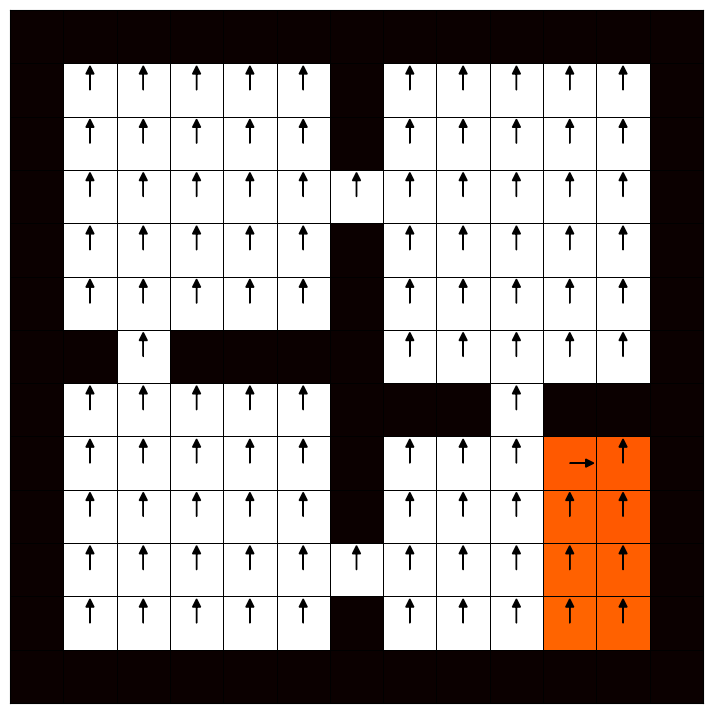

In [ ]:
gamma = 0.99
env = FourRoom()
Pi, v = policyIteration(env, gamma)
plot_grid_world(env, Pi, v)

In [ ]:
import numpy as np

def valueIteration(env, gamma, tol=1e-10):
    """
    Value Iteration algorithm for finding the optimal policy.

    Parameters:
    - env: GridWorld environment instance.
    - gamma: Discount factor.
    - tol: Tolerance for stopping the iteration.

    Returns:
    - Pi: Expanded policy matrix of an optimal policy.
    - v: Vector representing the state values of the policy.
    """

    n_states = env.n_states
    n_actions = env.n_actions

    # Initialize state values to zeros
    v = np.zeros(n_states)

    while True:
        delta = 0
        for s in range(n_states):
            v_old = v[s]

            # Compute Q-value for each action
            q_values = np.zeros(n_actions)
            for a in range(n_actions):
                q_values[a] = env.r[s * n_actions + a] + \
                    gamma * np.sum(env.P[s * n_actions + a] * v)

            # Update state value using the maximum Q-value
            v[s] = np.max(q_values)

            delta = max(delta, abs(v_old - v[s]))

        if delta < tol:
            break

    # Compute policy matrix Pi
    Pi = np.zeros((n_states, n_states * n_actions))
    for s in range(n_states):
        q_values = np.zeros(n_actions)
        for a in range(n_actions):
            q_values[a] = env.r[s * n_actions + a] + \
                gamma * np.sum(env.P[s * n_actions + a] * v)
        best_action = np.argmax(q_values)
        Pi[s, s * n_actions + best_action] = 1

    return Pi, v

<ipython-input-9-12a52e0010eb>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q_values[a] = env.r[s * n_actions + a] + \
<ipython-input-9-12a52e0010eb>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q_values[a] = env.r[s * n_actions + a] + \
<ipython-input-9-12a52e0010eb>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q_values[a] = env.r[s * n_actions + a] + \
<ipython-input-9-12a52e0010eb>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a 

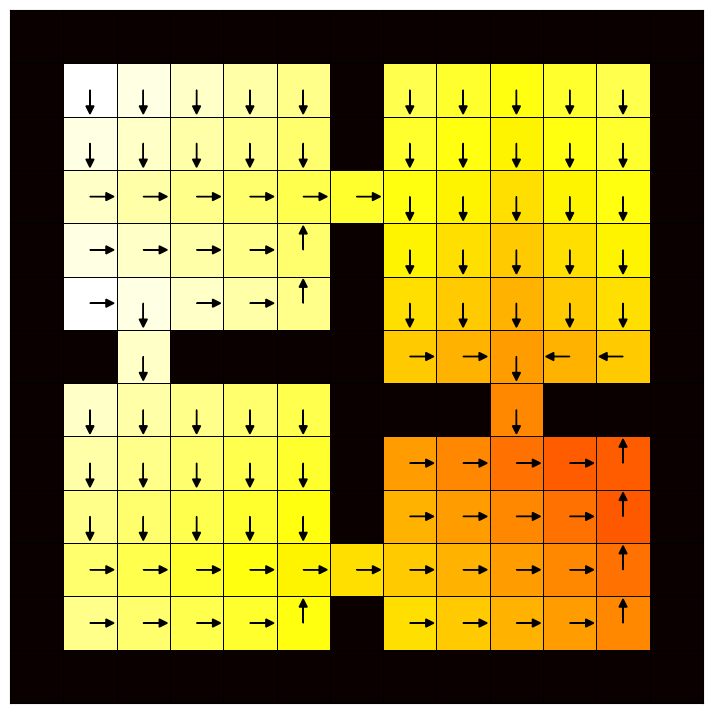

In [ ]:
gamma = 0.99
env = FourRoom()
Pi, v = valueIteration(env, gamma)
plot_grid_world(env, Pi, v)

Question **4** (a) - QLearning Function

In [ ]:
import numpy as np

def QLearning(env, gamma, alpha, epsilon, max_episodes):
    # Initialize Q-table with zeros
    num_states = env.n_states
    num_actions = env.n_actions
    Q = np.zeros((num_states, num_actions))

    # Q-learning algorithm
    for episode in range(max_episodes):
        state = env.reset()  # Reset environment to initial state
        done = False  # Whether the episode is finished

        while not done:
            # Epsilon-greedy policy
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(num_actions)  # Explore
            else:
                if isinstance(state, tuple) or isinstance(state, list):
                    if Q[state[0]] is not None:
                        action = np.argmax(Q[state[0]])  # Exploit
                    else:
                        action = np.argmax(Q[state])  # Exploit

            # Take action and observe next state and reward
            #print( env.step(action))
            next_state, reward, done = env.step(action)[:3]

            # Q-value update using the Bellman equation
            td_target = reward + gamma * np.max(Q[next_state])
            if isinstance(state, tuple) or isinstance(state, list):
                    if Q[state[0]] is not None:
                       td_error = td_target - Q[state[0], action]
                       Q[state[0], action] += alpha * td_error
                    else:
                       td_error = td_target - Q[state, action]
                       Q[state, action] += alpha * td_error

            # Move to next state
            state = next_state

    # Derive policy from Q-table
    policy = np.argmax(Q, axis=1)

    return policy, Q

In [ ]:
gamma = 0.99
step_size=0.1
epsilon=0.1
max_episode=500
env = FourRoom()
Pi, v = QLearning(env, gamma, step_size , epsilon , max_episode )
#plot_grid_world(env, Pi, v)

In [ ]:
print(Pi)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
import numpy as np

def runQLExperiments(env):
    def repeatExperiments(gamma=0.9, step_size=0.1, epsilon=0.1, max_episode=500):
        n_runs = 5
        RMSE = np.zeros(n_runs)
        for r in range(n_runs):
            Pi, q = QLearning(env, gamma, step_size, epsilon, max_episode)

            q_star = np.load('/content/optimal_q.npy')
            print("q shape:", q.shape)
            q_star_reshaped = np.tile(q_star, (1, 4))
            print("NaNs in q:", np.isnan(q).any())
            print("NaNs in q_star_reshaped:", np.isnan(q_star_reshaped).any())


            RMSE[r] = np.sqrt(np.mean((q - q_star_reshaped)**2))
        return np.mean(RMSE)  # Average RMSE over runs

    step_size_list = [0.1, 0.2, 0.5, 0.9]
    epsilon_list = [0.05, 0.1, 0.5, 0.9]
    max_episode_list = [50, 100, 500, 1000]

    step_size_results = np.zeros(len(step_size_list))
    epsilon_results = np.zeros(len(epsilon_list))
    max_episode_results = np.zeros(len(max_episode_list))

    # Iterate through different step sizes
    for i, step_size in enumerate(step_size_list):
        step_size_results[i] = repeatExperiments(step_size=step_size)

    # Iterate through different epsilons
    for i, epsilon in enumerate(epsilon_list):
        epsilon_results[i] = repeatExperiments(epsilon=epsilon)

    # Iterate through different max episodes
    for i, max_episode in enumerate(max_episode_list):
        max_episode_results[i] = repeatExperiments(max_episode=max_episode)

    return step_size_results, epsilon_results, max_episode_results

Question 4 - b

In [ ]:
env = FourRoom(goal=0)

step_size_results, epsilon_results, max_episode_results = runQLExperiments(env)

print("Step Size Results:", step_size_results)
print("Epsilon Results:", epsilon_results)
print("Max Episode Results:", max_episode_results)